In [2]:
%autosave 0

Autosave disabled


In [58]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier, plot_tree

from adam_prepare import titanic_pipeline

Let's read in our data using the titanic_pipeline function!

In [8]:
train, val, test = titanic_pipeline()

Let's take a peek at train. Some of my values are strings. Can (most) machine learning models handle strings?

In [5]:
train.head()

,survived,sex,age,sibsp,parch,fare,class,embark_town,alone
748,0,male,19.0,1,0,53.1000,First,Southampton,0
45,0,male,29.0,0,0,8.0500,Third,Southampton,1
28,1,female,29.0,0,0,7.8792,Third,Queenstown,1
633,0,male,29.0,0,0,0.0000,First,Southampton,1
403,0,male,28.0,1,0,15.8500,Third,Southampton,0


We need to determine a way to meaningfully encode our string values.

We will use [pd.get_dummies](https://pandas.pydata.org/docs/reference/api/pandas.get_dummies.html) to [one-hot encode](https://machinelearningmastery.com/why-one-hot-encode-data-in-machine-learning/) our categorical columns.

In [9]:
train = pd.get_dummies(train, columns = ['sex'], drop_first= True)
train = pd.get_dummies(train, columns = ['class', 'embark_town'])
train.head()

,survived,age,sibsp,parch,fare,alone,sex_male,class_First,class_Second,class_Third,embark_town_Cherbourg,embark_town_Queenstown,embark_town_Southampton
748,0,19.0,1,0,53.1000,0,True,True,False,False,False,False,True
45,0,29.0,0,0,8.0500,1,True,False,False,True,False,False,True
28,1,29.0,0,0,7.8792,1,False,False,False,True,False,True,False
633,0,29.0,0,0,0.0000,1,True,True,False,False,False,False,True
403,0,28.0,1,0,15.8500,0,True,False,False,True,False,False,True


In [11]:
train.shape , val.shape

((623, 13), (134, 9))

In [12]:
val = pd.get_dummies(val, columns = ['sex'], drop_first= True)
val = pd.get_dummies(val, columns = ['class', 'embark_town'])
val.head()

,survived,age,sibsp,parch,fare,alone,sex_male,class_First,class_Second,class_Third,embark_town_Cherbourg,embark_town_Queenstown,embark_town_Southampton
377,0,27.0,0,2,211.500,0,True,True,False,False,True,False,False
244,0,30.0,0,0,7.225,1,True,False,False,True,True,False,False
72,0,21.0,0,0,73.500,1,True,False,True,False,False,False,True
815,0,29.0,0,0,0.000,1,True,True,False,False,False,False,True
841,0,16.0,0,0,10.500,1,True,False,True,False,False,False,True


Let's make sure our three subsets (train, validate) all have the same number of columns!

In [13]:
train.shape, val.shape

((623, 13), (134, 13))

Now that our categorical data is properly encoded, let's make X and y dataframes for model training and evaluation.

In [14]:
x_train = train.drop(columns = ['survived'])
y_train = train.survived

x_val = val.drop(columns = ['survived'])
y_val = val.survived

We should define a baseline before we get started! Our baseline will be the most likely outcome from the y_train series.

In [21]:
y_train.mode()

0    0
Name: survived, dtype: int64

In [24]:
base_acc =  (y_train == 0).mean()
base_acc

0.6163723916532905

We're ready to model! Let's create an instance of a [DecisionTreeClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html) and fit it to our train dataset.

In [25]:
seed = 42

clf = DecisionTreeClassifier(random_state = seed)

clf.fit(x_train, y_train)

DecisionTreeClassifier(random_state=42)

Let's check out the .feature_importances_ attribute.

In [26]:
clf.feature_importances_

array([0.24829184, 0.03593243, 0.02165793, 0.2299886 , 0.01765126,
       0.32440375, 0.02824841, 0.00442031, 0.07023397, 0.00777043,
       0.00046198, 0.0109391 ])

In [28]:
x_train.columns

Index(['age', 'sibsp', 'parch', 'fare', 'alone', 'sex_male', 'class_First',
       'class_Second', 'class_Third', 'embark_town_Cherbourg',
       'embark_town_Queenstown', 'embark_town_Southampton'],
      dtype='object')

In [30]:
imp = pd.DataFrame({'cols': x_train.columns,
                   'imps':clf.feature_importances_})

imp.sort_values(by = 'imps' , ascending = False)

,cols,imps
5,sex_male,0.324404
0,age,0.248292
3,fare,0.229989
8,class_Third,0.070234
1,sibsp,0.035932
6,class_First,0.028248
2,parch,0.021658
4,alone,0.017651
11,embark_town_Southampton,0.010939
9,embark_town_Cherbourg,0.007770


Let's make some predictions with the .predict() method and save them to a variable.

In [33]:
train_preds = clf.predict(x_train)
train_preds[:5]

array([0, 0, 1, 0, 0])

Let's evaluate the accuracy of our model with the .score() method.

In [34]:
clf.score(x_train, y_train)

0.9759229534510433

We can use the classification_report function to return a whole host of metrics about our model!

In [35]:
print(classification_report(y_train, train_preds))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98       384
           1       1.00      0.94      0.97       239

    accuracy                           0.98       623
   macro avg       0.98      0.97      0.97       623
weighted avg       0.98      0.98      0.98       623



Wow! My model is incredible! I'm sure it will be equally awesome on the validate dataset!

In [36]:
clf.score(x_val ,y_val)

0.7910447761194029

What does it mean to be overfit?

What does it mean to be overfit?

My train accuracy is 98% and my validate accuracy is 79%

My model is NOT generalizing well to unseen data!

In [54]:
seed = 42
train_acc = []
val_acc = []
depth = []

for i in range(2, 6):
    clf = DecisionTreeClassifier(max_depth = i , random_state = seed)
    clf.fit(x_train, y_train)
    
    train_acc.append(clf.score(x_train, y_train))
    val_acc.append(clf.score(x_val,y_val))
    depth.append(clf.score(x_val, y_val))

In [56]:
trees = pd.DataFrame({'max_depth': depth,
                      'train_acc': train_acc,
                      'val_acc': val_acc})
trees

,max_depth,train_acc,val_acc
0,0.798507,0.807384,0.798507
1,0.835821,0.829856,0.835821
2,0.835821,0.845907,0.835821
3,0.820896,0.863563,0.820896


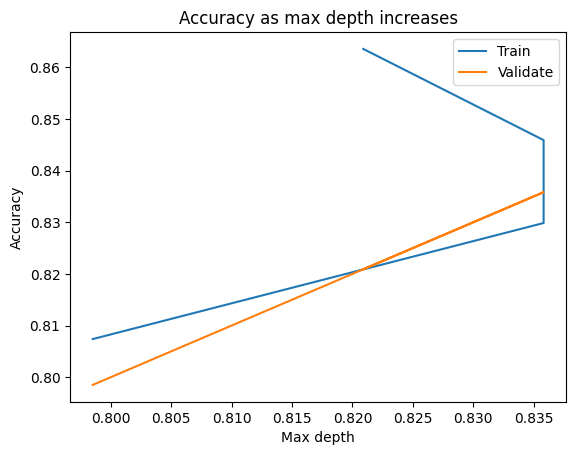

In [57]:
plt.plot(trees.max_depth, trees.train_acc, label = 'Train')
plt.plot(trees.max_depth, trees.val_acc, label = 'Validate')
plt.ylabel('Accuracy')
plt.xlabel('Max depth')
plt.title('Accuracy as max depth increases')
plt.legend()
plt.show()